# Stock Market Prediction using Machine Learning 

### Importing Libraries

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import yfinance as yf

### Getting Data

In [4]:

tickers = ['TRIDENT.NS','TCS.NS']
start = dt.datetime.today() - dt.timedelta(5 * 365)
end = dt.datetime.today()

for i in tickers:
    data = yf.download(i,start,end)
    data.to_csv(f'{i}.csv', index=True)

a = data.sort_values('Date')
print(a)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-04-16  2120.000000  2155.949951  2115.550049  2131.800049  1907.931763   
2019-04-18  2149.899902  2155.000000  2114.199951  2150.050049  1924.265259   
2019-04-22  2148.000000  2176.000000  2145.600098  2161.449951  1934.467651   
2019-04-23  2163.000000  2165.500000  2134.050049  2155.050049  1928.739502   
2019-04-24  2158.000000  2195.000000  2156.100098  2183.449951  1954.157349   
...                 ...          ...          ...          ...          ...   
2024-04-05  3978.000000  4002.000000  3960.500000  3979.250000  3979.250000   
2024-04-08  3983.000000  4032.649902  3960.000000  3972.550049  3972.550049   
2024-04-09  3984.000000  4015.850098  3925.050049  3946.550049  3946.550049   
2024-04-10  3956.399902  3990.199951  3918.000000  3984.649902  3984.649902   
2024-04-12  3971.000000  4013.350098  3945.500000  4

We will implement our models/techniques on different 3 stocks based on market size.

In [5]:
tcs = pd.read_csv('TCS.NS.csv')

trident = pd.read_csv('TRIDENT.NS.csv')

### LSTM

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

 - The input gate: The input gate adds information to the cell state

 - The forget gate: It removes the information that is no longer required by the model

 - The output gate: Output Gate at LSTM selects the information to be shown as output


#### On TCS

                  Date         Open         High          Low        Close  \
Date                                                                         
2019-04-16  2019-04-16  2120.000000  2155.949951  2115.550049  2131.800049   
2019-04-18  2019-04-18  2149.899902  2155.000000  2114.199951  2150.050049   
2019-04-22  2019-04-22  2148.000000  2176.000000  2145.600098  2161.449951   
2019-04-23  2019-04-23  2163.000000  2165.500000  2134.050049  2155.050049   
2019-04-24  2019-04-24  2158.000000  2195.000000  2156.100098  2183.449951   

              Adj Close   Volume  
Date                              
2019-04-16  1907.931763  5771952  
2019-04-18  1924.265259  3413728  
2019-04-22  1934.467651  2007135  
2019-04-23  1928.739502  2163524  
2019-04-24  1954.157349  3003071  
                  Date         Open         High          Low        Close  \
Date                                                                         
2019-04-16  2019-04-16  2120.000000  2155.949951  21

Text(0.5, 1.0, 'Predicted adj close price vs actual close price on TCS ')

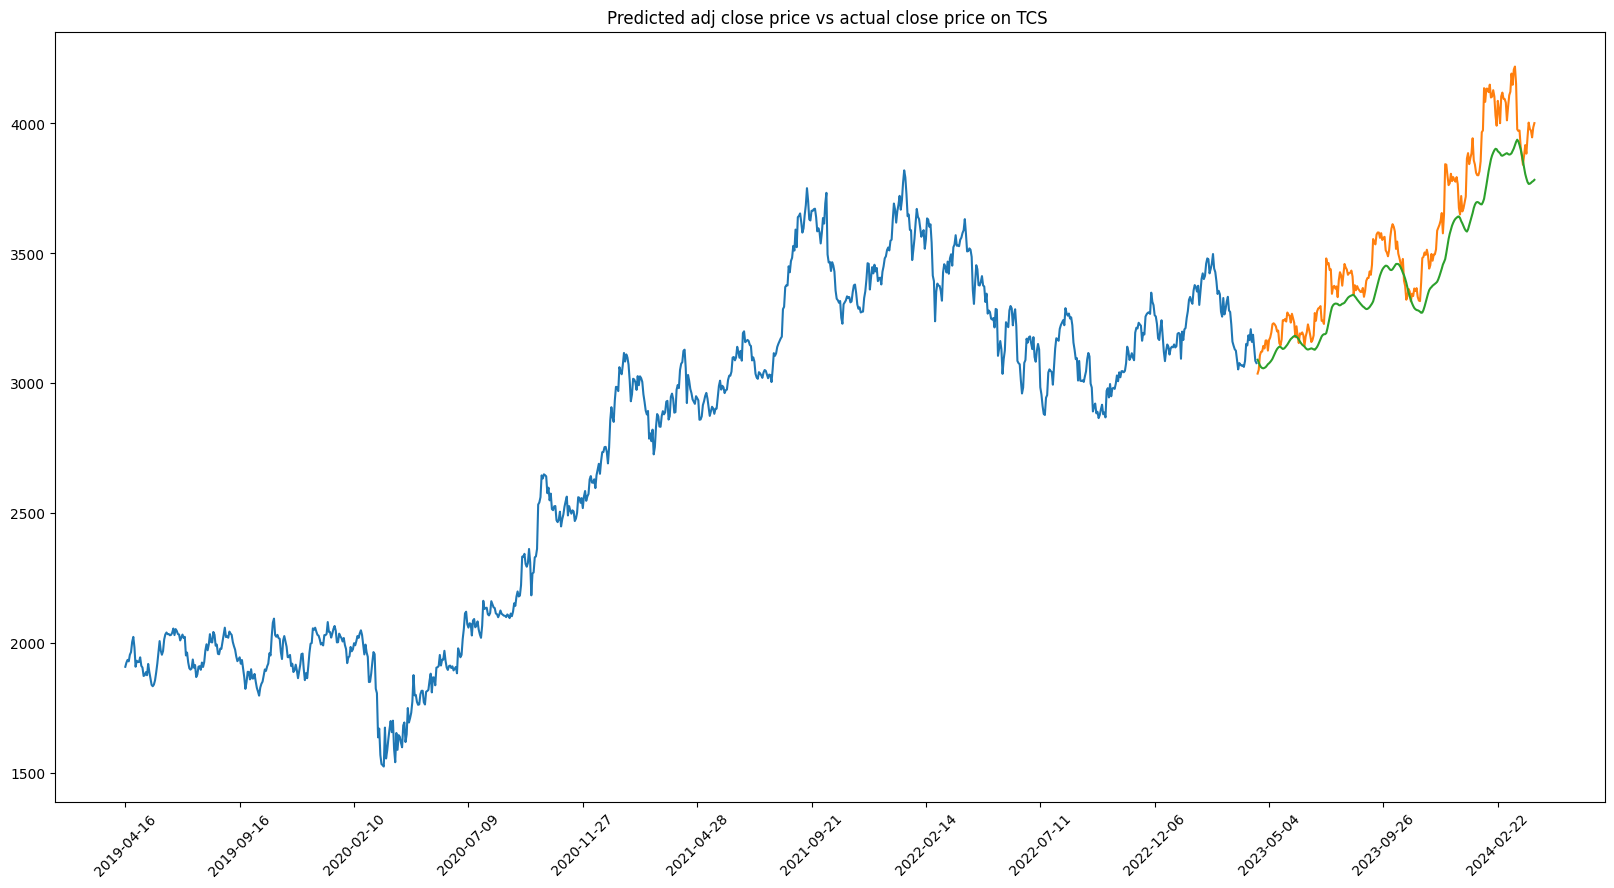

In [7]:
tcs = pd.read_csv('TCS.NS.csv')
tcs.index=tcs['Date']

tcs_df = tcs.sort_index(ascending=True, axis=0)
tcs_new = pd.DataFrame(index=range(0, len(tcs)), columns=['Date', 'Adj Close'])

for i in range(0,len(tcs_df)):
    tcs_new['Date'][i] = tcs_df['Date'][i]
    tcs_new['Adj Close'][i] = tcs_df['Adj Close'][i]
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error
tcs_lstm = pd.DataFrame(index=range(0,len(tcs_df)),columns=['Date', 'Adj Close'])
for i in range(0,len(tcs_df)):
    tcs_lstm['Date'][i] = tcs_df['Date'][i]
    tcs_lstm['Adj Close'][i] = tcs_df['Adj Close'][i]

tcs_lstm.index = tcs_lstm.Date
tcs_lstm.drop('Date', axis=1, inplace=True)

dataset = tcs_lstm.values

train = dataset[0:990,:]
valid = dataset[990:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
print('Fitting Model')
inputs = tcs_lstm[len(tcs_lstm) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(mean_squared_error(closing_price,valid))
print('RMSE is',rms)

train = tcs_lstm[:990]
valid = tcs_lstm[990:]
valid['Predictions'] = closing_price
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.xticks(range(0,tcs_df.shape[0],100),tcs_df['Date'].loc[::100],rotation=45)
plt.title('Predicted adj close price vs actual close price on TCS ')

#### On Trident

930/930 - 32s - loss: 0.0030 - 32s/epoch - 35ms/step
Fitting Model
8/8 [==============================] - 1s 21ms/step
RMSE is 2.013179681856879


Text(0.5, 1.0, 'Predicted adj close price vs actual close price on Trident ')

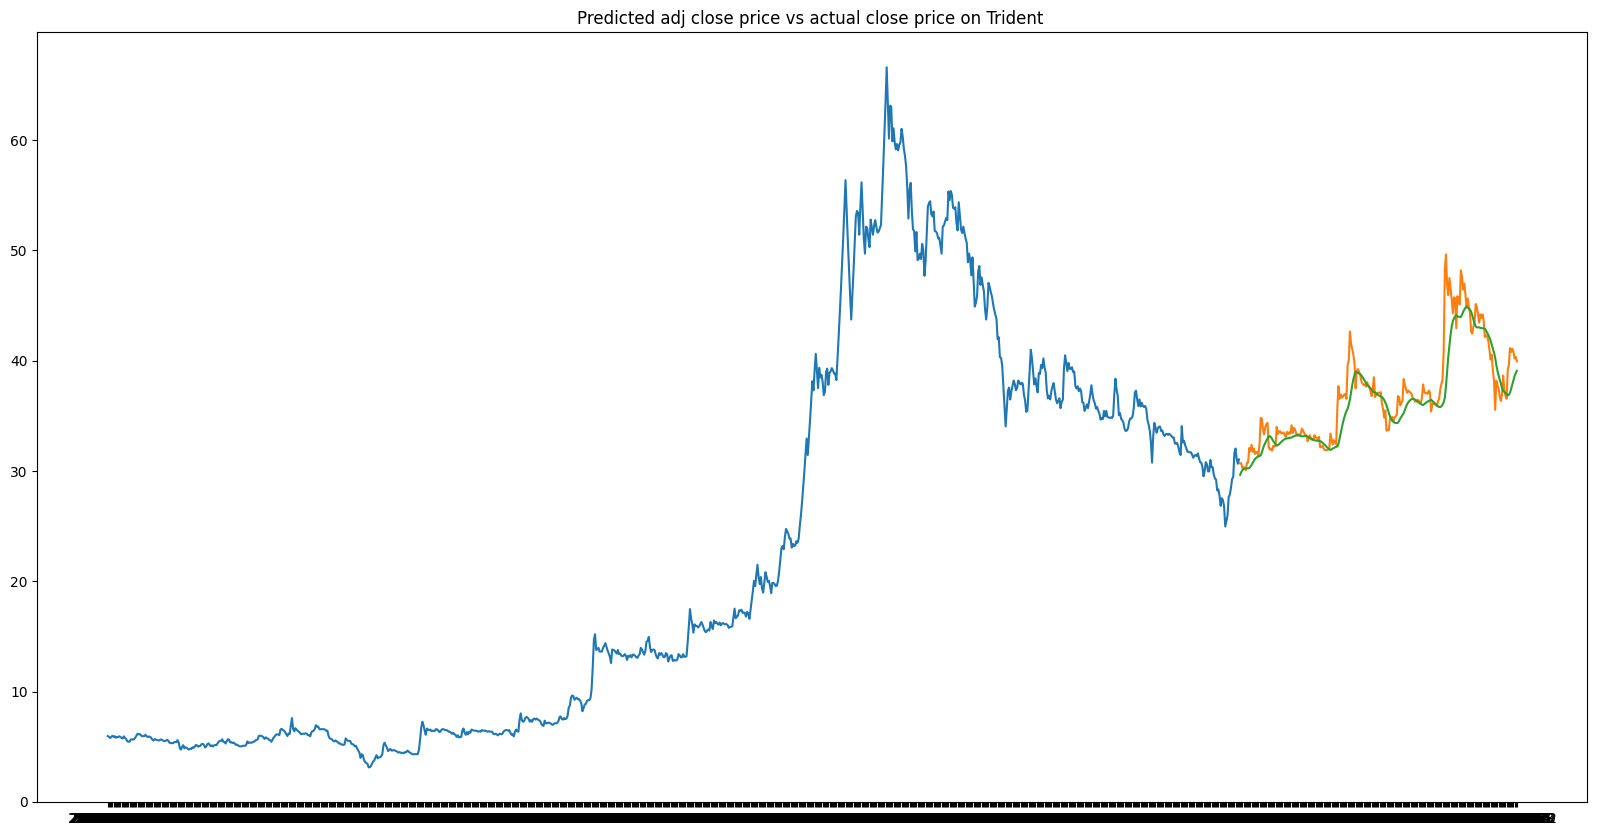

In [ ]:
tri_lstm = pd.DataFrame(index=range(0,len(trident)),columns=['Date', 'Adj Close'])
for i in range(0,len(trident)):
    tri_lstm['Date'][i] = trident['Date'][i]
    tri_lstm['Adj Close'][i] = trident['Adj Close'][i]

tri_lstm.index = tri_lstm.Date
tri_lstm.drop('Date', axis=1, inplace=True)


dataset = tri_lstm.values

train = dataset[0:990,:]
valid = dataset[990:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
print('Fitting Model')
inputs = tri_lstm[len(tri_lstm) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(mean_squared_error(closing_price,valid))
print('RMSE is',rms)

train = tri_lstm[:990]
valid = tri_lstm[990:]
valid['Predictions'] = closing_price
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.title('Predicted adj close price vs actual close price on Trident ')